In [1]:
%matplotlib inline


# Complex Resonator Model

This notebook shows how to fit the parameters of a complex resonator,
using `lmfit.Model` and defining a custom `Model` class.

Following Khalil et al. (https://arxiv.org/abs/1108.3117), we can model the
forward transmission of a microwave resonator with total quality factor
$Q$, coupling quality factor $Q_e$, and resonant frequency
$f_0$ using:

\begin{align}S_{21}(f) = 1 - \frac{Q Q_e^{-1}}{1+2jQ(f-f_0)/f_0}\end{align}

$S_{21}$ is thus a complex function of a real frequency.

By allowing $Q_e$ to be complex, this model can take into account
mismatches in the input and output transmission impedances.


In [2]:
import matplotlib.pyplot as plt
import numpy as np

import lmfit

Since ``scipy.optimize`` and ``lmfit`` require real parameters, we represent
$Q_e$ as ``Q_e_real + 1j*Q_e_imag``.



In [3]:
def linear_resonator(f, f_0, Q, Q_e_real, Q_e_imag):
    Q_e = Q_e_real + 1j*Q_e_imag
    return 1 - (Q * Q_e**-1 / (1 + 2j * Q * (f - f_0) / f_0))

The standard practice of defining a ``lmfit`` model is as follows:



In [4]:
class ResonatorModel(lmfit.model.Model):
    __doc__ = "resonator model" + lmfit.models.COMMON_INIT_DOC

    def __init__(self, *args, **kwargs):
        # pass in the defining equation so the user doesn't have to later
        super().__init__(linear_resonator, *args, **kwargs)

        self.set_param_hint('Q', min=0)  # enforce Q is positive

    def guess(self, data, f=None, **kwargs):
        verbose = kwargs.pop('verbose', None)
        if f is None:
            return
        argmin_s21 = np.abs(data).argmin()
        fmin = f.min()
        fmax = f.max()
        f_0_guess = f[argmin_s21]  # guess that the resonance is the lowest point
        Q_min = 0.1 * (f_0_guess/(fmax-fmin))  # assume the user isn't trying to fit just a small part of a resonance curve
        delta_f = np.diff(f)  # assume f is sorted
        min_delta_f = delta_f[delta_f > 0].min()
        Q_max = f_0_guess/min_delta_f  # assume data actually samples the resonance reasonably
        Q_guess = np.sqrt(Q_min*Q_max)  # geometric mean, why not?
        Q_e_real_guess = Q_guess/(1-np.abs(data[argmin_s21]))
        if verbose:
            print(f"fmin={fmin}, fmax={fmax}, f_0_guess={f_0_guess}")
            print(f"Qmin={Q_min}, Q_max={Q_max}, Q_guess={Q_guess}, Q_e_real_guess={Q_e_real_guess}")
        params = self.make_params(Q=Q_guess, Q_e_real=Q_e_real_guess, Q_e_imag=0, f_0=f_0_guess)
        params[f'{self.prefix}Q'].set(min=Q_min, max=Q_max)
        params[f'{self.prefix}f_0'].set(min=fmin, max=fmax)
        return lmfit.models.update_param_vals(params, self.prefix, **kwargs)

Now let's use the model to generate some fake data:



Text(0.5, 1.0, 'simulated measurement')

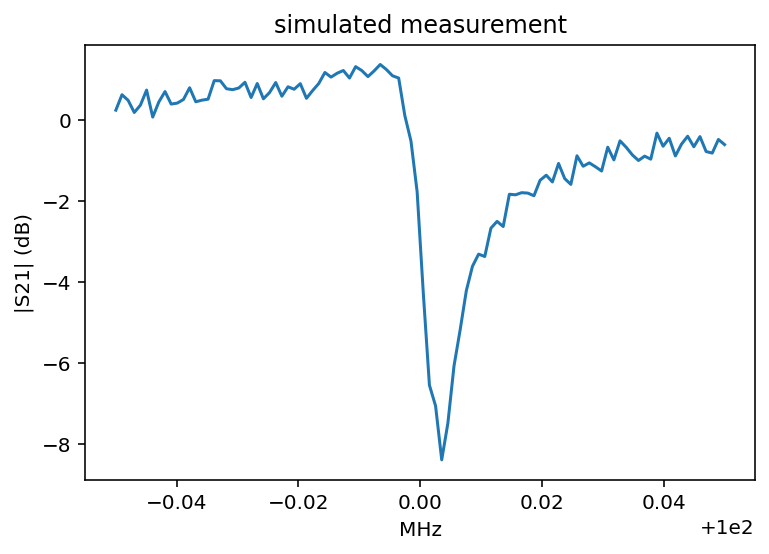

In [5]:
resonator = ResonatorModel()
true_params = resonator.make_params(f_0=100, Q=10000, Q_e_real=9000, Q_e_imag=-9000)

f = np.linspace(99.95, 100.05, 100)
true_s21 = resonator.eval(params=true_params, f=f)
noise_scale = 0.02
np.random.seed(123)
measured_s21 = true_s21 + noise_scale*(np.random.randn(100) + 1j*np.random.randn(100))

plt.plot(f, 20*np.log10(np.abs(measured_s21)))
plt.ylabel('|S21| (dB)')
plt.xlabel('MHz')
plt.title('simulated measurement')

Try out the ``guess`` method we added:



In [6]:
guess = resonator.guess(measured_s21, f=f, verbose=True)

fmin=99.95, fmax=100.05, f_0_guess=100.00353535353536
Qmin=100.00353535354105, Q_max=99003.50000055433, Q_guess=3146.537781821432, Q_e_real_guess=5082.2474265369565


And now fit the data using the ``guess``-ed values as a starting point:



In [7]:
result = resonator.fit(measured_s21, params=guess, f=f, verbose=True)

print(result.fit_report() + '\n')
result.params.pretty_print()

[[Model]]
    Model(linear_resonator)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 36
    # data points      = 200
    # variables        = 4
    chi-square         = 0.08533642
    reduced chi-square = 4.3539e-04
    Akaike info crit   = -1543.89425
    Bayesian info crit = -1530.70099
[[Variables]]
    f_0:       100.000096 +/- 7.0378e-05 (0.00%) (init = 100.0035)
    Q:         10059.4926 +/- 142.294761 (1.41%) (init = 3146.538)
    Q_e_real:  9180.61935 +/- 133.776862 (1.46%) (init = 5082.247)
    Q_e_imag: -9137.03303 +/- 133.770211 (1.46%) (init = 0)
[[Correlations]] (unreported correlations are < 0.100)
    C(Q, Q_e_real)   = 0.518
    C(f_0, Q_e_imag) = 0.517
    C(f_0, Q_e_real) = 0.515
    C(Q, Q_e_imag)   = -0.515

Name         Value      Min      Max   Stderr     Vary     Expr Brute_Step
Q         1.006e+04      100  9.9e+04    142.3     True     None     None
Q_e_imag     -9137     -inf      inf    133.8     True     None     None
Q_e_real  

Now we'll make some plots of the data and fit. Define a convenience function
for plotting complex quantities:



Text(0.5, 0, 'MHz')

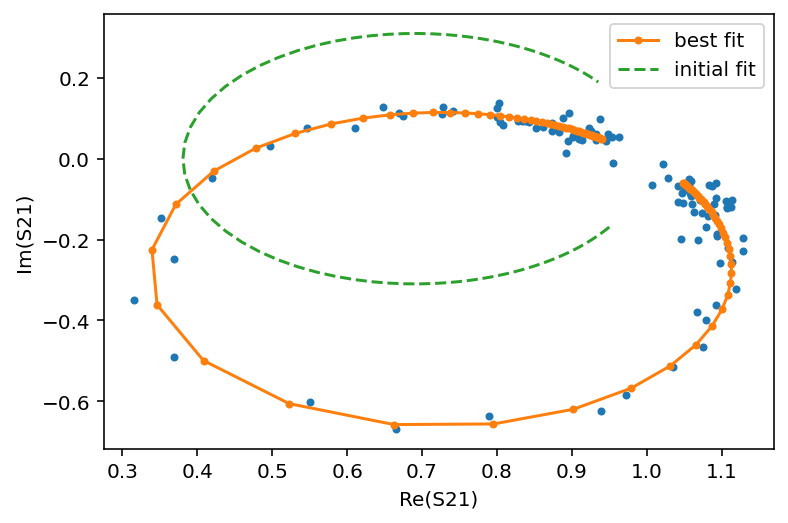

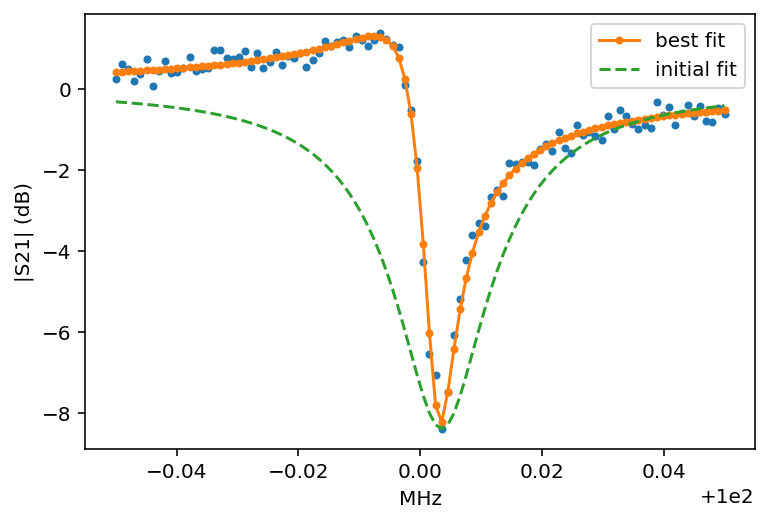

In [8]:
def plot_ri(data, *args, **kwargs):
    plt.plot(data.real, data.imag, *args, **kwargs)


fit_s21 = resonator.eval(params=result.params, f=f)
guess_s21 = resonator.eval(params=guess, f=f)

plt.figure()
plot_ri(measured_s21, '.')
plot_ri(fit_s21, '.-', label='best fit')
plot_ri(guess_s21, '--', label='initial fit')
plt.legend()
plt.xlabel('Re(S21)')
plt.ylabel('Im(S21)')

plt.figure()
plt.plot(f, 20*np.log10(np.abs(measured_s21)), '.')
plt.plot(f, 20*np.log10(np.abs(fit_s21)), '.-', label='best fit')
plt.plot(f, 20*np.log10(np.abs(guess_s21)), '--', label='initial fit')
plt.legend()
plt.ylabel('|S21| (dB)')
plt.xlabel('MHz')